In [1]:
from keras.applications import VGG16
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os

Using TensorFlow backend.


In [2]:
img_size = 224
batch_size = 64
EPOCHS = 30

In [3]:
labels = pd.read_csv('../MTLData/csv/data.csv',dtype=str,delimiter=",")
labels = labels.sample(frac=1).reset_index(drop=True) #Shuffle data
labels['Image'] = labels['Image'].astype(str)  

In [4]:
labels['Image'].head(100)

0     3082_14
1     3303_24
2      3318_5
3      3348_1
4     3278_12
       ...   
95    3342_21
96    3266_24
97    3139_22
98    3089_28
99    3284_14
Name: Image, Length: 100, dtype: object

In [5]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(img_size, img_size, 3)))
flatLayer = baseModel.output
sharedLayer = Flatten(name="flatten")(flatLayer)
sharedLayer = Dense(1024,name="Shared")(sharedLayer)
#sharedLayer = Dropout(0.5)(sharedLayer)
task1 = Dense(512, activation="relu")(sharedLayer)
task1 = Dense(10, activation="softmax",name='PFR')(task1)
task2 = Dense(512, activation="relu")(sharedLayer)
task2 = Dense(5, activation="softmax",name='FT')(task2)
model3 = Model(inputs=baseModel.input, outputs=[task1,task2])

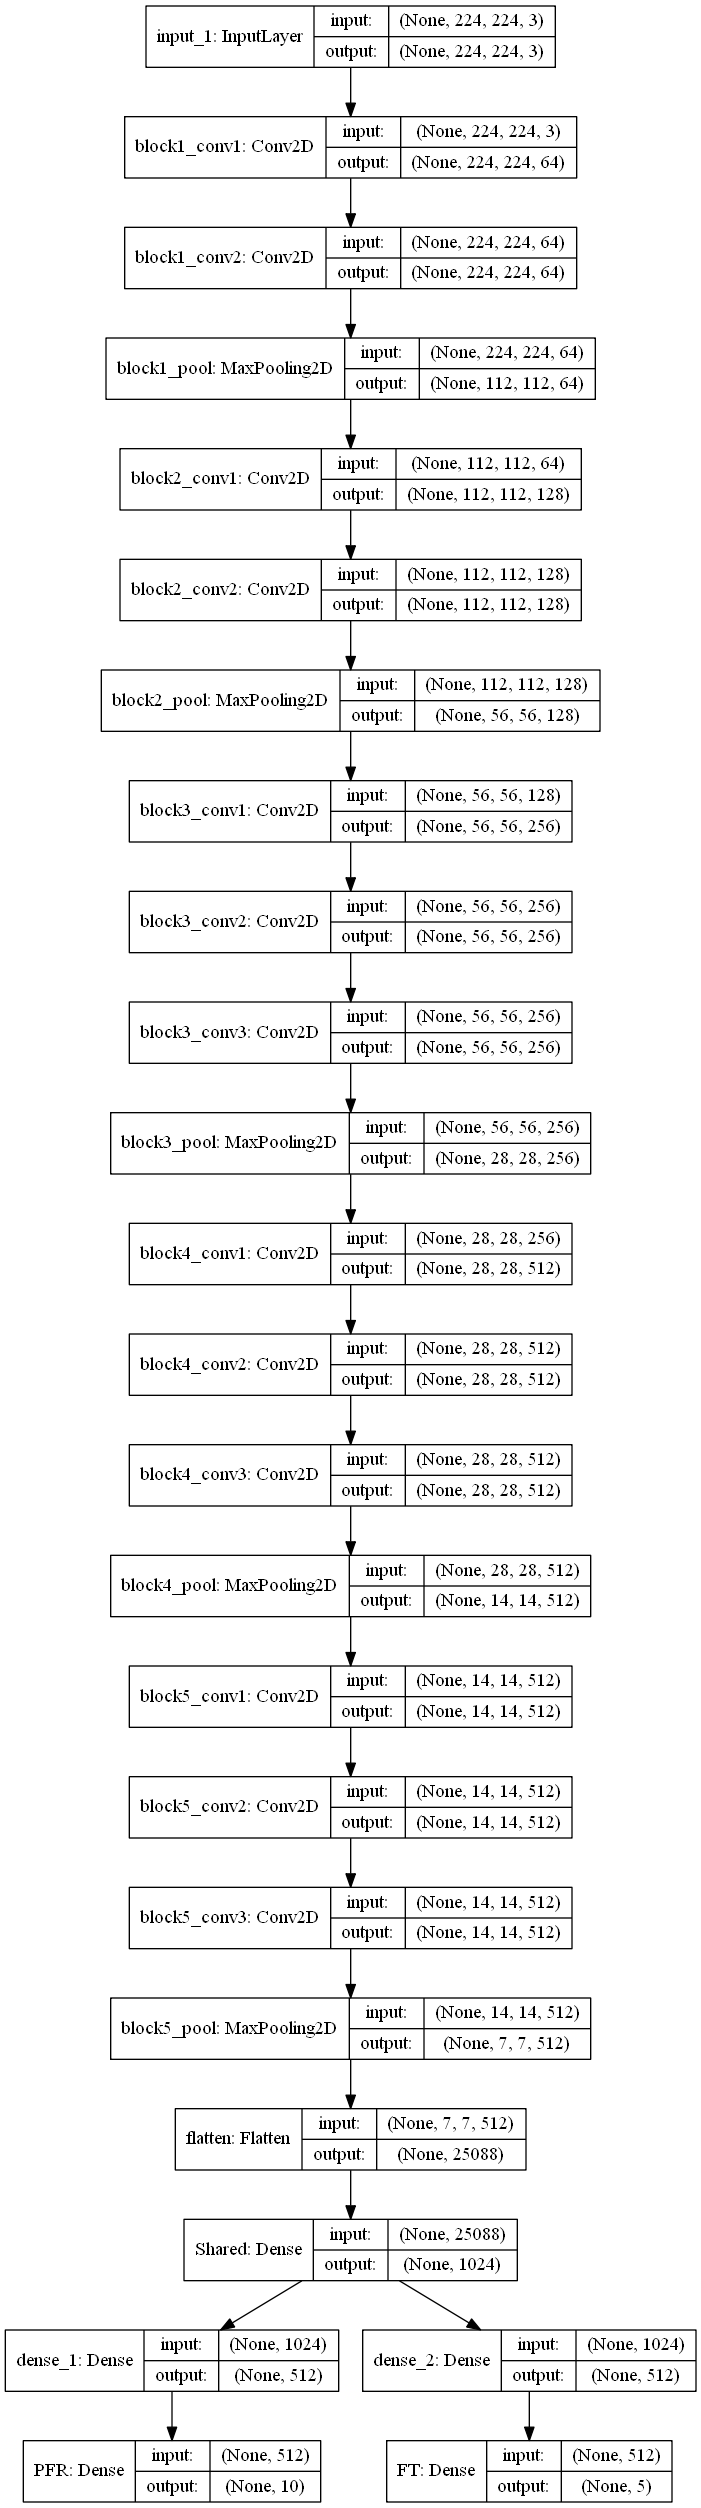

In [6]:
plot_model(model3, show_shapes=True, show_layer_names=True)

In [7]:
losses = {
    "PFR": "categorical_crossentropy",
    "FT": "categorical_crossentropy",
}

metric = {
    "PFR":'accuracy',
    "FT": "accuracy",
}
lossWeights = {"PFR": 10.0, "FT": 1.0}
opt = SGD(lr=1e-5, momentum=0.8)
model3.compile(optimizer=opt,loss=losses,
               loss_weights=lossWeights,
               metrics=metric)

In [8]:
cols = ['Image','PFRType','FuelType','dir']
labels = labels[cols]

In [9]:
pfr_label_encoder = LabelEncoder()
pfr_label_encoder.fit(labels.PFRType)
pfrEncoded = pfr_label_encoder.transform(labels.PFRType)

ft_label_encoder = LabelEncoder()
ft_label_encoder.fit(labels.FuelType)
ftEncoded = ft_label_encoder.transform(labels.FuelType)

labels.PFRType = pfrEncoded
labels.FuelType = ftEncoded


In [10]:
labels.Image = labels.Image.astype(str)+'.jpg'
labels.head()

,Image,PFRType,FuelType,dir
0,3082_14.jpg,0,1,vald
1,3303_24.jpg,6,3,train
2,3318_5.jpg,0,3,train
3,3348_1.jpg,0,4,train
4,3278_12.jpg,0,2,train


In [11]:
# trying flow from dataframe

In [12]:
trainGen = ImageDataGenerator()
trainGenDf = trainGen.flow_from_dataframe(dataframe=labels[labels.dir == 'train'],
                                         directory = '../MTLData/train/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)
valdGen = ImageDataGenerator()
valdGenDf = valdGen.flow_from_dataframe(dataframe=labels[labels.dir == 'vald'],
                                         directory = '../MTLData/vald/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)
testGen = ImageDataGenerator()
testGenDf = valdGen.flow_from_dataframe(dataframe=labels[labels.dir == 'test'],
                                         directory = '../MTLData/test/',
                                         x_col = "Image",y_col=["PFRType","FuelType"],
                                         class_mode='multi_output',
                                         target_size=(224,224),
                                         batch_size=32)

Found 7309 validated image filenames.
Found 1556 validated image filenames.
Found 1554 validated image filenames.


In [13]:
STEP_SIZE_TRAIN=trainGenDf.n//batch_size
STEP_SIZE_VALID=valdGenDf.n//batch_size
STEP_SIZE_TEST=testGenDf.n//batch_size

In [14]:
class CustonGen:
    def __init__(self):
        self.trainClsPfr, self.trainClsFt = [],[]
        self.testClsPfr, self.testClsFt = [],[]
        self.valdClsPfr, self.valdClsFt = [],[]
    
    def get_data_generator(self, data, split ,batch_size=16):

        imagePath = ''
        df =''

        if split == 'train':
            imagePath = '../MTLData/train/'
            df = data[data.dir == 'train']
            self.trainStep = df.shape[0]//batch_size
        elif split == 'test':
            imagePath = '../MTLData/test/'
            df = data[data.dir == 'test']
            self.testStep = df.shape[0]//batch_size
        elif split == 'vald':
            imagePath = '../MTLData/vald/'
            df = data[data.dir == 'vald']
            self.valdStep = df.shape[0]//batch_size

        pfrID = len(data.PFRType.unique())
        ftID = len(data.FuelType.unique())
        images, pfrs,fts = [], [], []
        while True:
            for i in range(0,df.shape[0]):
                r = df.iloc[i]
                file, pfr, ft = r['Image'], r['PFRType'], r['FuelType']
                im = Image.open(imagePath+file)
                im = im.resize((224, 224))
                im = np.array(im) / 255.0
                images.append(im)

                if split == 'train':
                    self.trainClsPfr.append(pfr)
                    self.trainClsFt.append(ft)
                elif split == 'vald':
                    self.valdClsPfr.append(pfr)
                    self.valdClsFt.append(ft)
                elif split == 'test':
                    self.testClsPfr.append(pfr)
                    self.testClsFt.append(ft)
                    
                pfrs.append(to_categorical(pfr, pfrID))
                fts.append(to_categorical(ft, ftID))
                
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(pfrs), np.array(fts)]
                    images, pfrs, fts = [], [], []
generator = CustonGen()

In [ ]:
H = model3.fit_generator(generator=get_data_generator(labels,'train',batch_size),
                    steps_per_epoch=STEP_SIZE_TRAIN+1,
                    validation_data=get_data_generator(labels,'vald',batch_size),
                    validation_steps=STEP_SIZE_VALID+1,
                    epochs=EPOCHS
)

In [15]:
# Using generator Class
H = model3.fit_generator(generator=generator.get_data_generator(labels,'train',batch_size),
                    steps_per_epoch=STEP_SIZE_TRAIN+1,
                    validation_data=generator.get_data_generator(labels,'vald',batch_size),
                    validation_steps=STEP_SIZE_VALID+1,
                    epochs=EPOCHS
)

Epoch 1/30
115/115 [==============================] - 129s 1s/step - loss: 15.3115 - PFR_loss: 1.4080 - FT_loss: 1.2315 - PFR_accuracy: 0.5553 - FT_accuracy: 0.5136 - val_loss: 11.6159 - val_PFR_loss: 1.0665 - val_FT_loss: 1.0734 - val_PFR_accuracy: 0.6381 - val_FT_accuracy: 0.6144
Epoch 2/30
115/115 [==============================] - 120s 1s/step - loss: 8.9985 - PFR_loss: 0.8156 - FT_loss: 0.8421 - PFR_accuracy: 0.7135 - FT_accuracy: 0.7090 - val_loss: 6.6130 - val_PFR_loss: 0.5722 - val_FT_loss: 0.6375 - val_PFR_accuracy: 0.8169 - val_FT_accuracy: 0.7812
Epoch 3/30
115/115 [==============================] - 121s 1s/step - loss: 5.0151 - PFR_loss: 0.4560 - FT_loss: 0.4551 - PFR_accuracy: 0.8367 - FT_accuracy: 0.8613 - val_loss: 4.3265 - val_PFR_loss: 0.3823 - val_FT_loss: 0.3378 - val_PFR_accuracy: 0.8506 - val_FT_accuracy: 0.8981
Epoch 4/30
115/115 [==============================] - 120s 1s/step - loss: 3.3230 - PFR_loss: 0.3050 - FT_loss: 0.2726 - PFR_accuracy: 0.8895 - FT_accuracy

115/115 [==============================] - 121s 1s/step - loss: 0.2531 - PFR_loss: 0.0217 - FT_loss: 0.0357 - PFR_accuracy: 0.9948 - FT_accuracy: 0.9895 - val_loss: 0.4943 - val_PFR_loss: 0.0850 - val_FT_loss: 0.0509 - val_PFR_accuracy: 0.9700 - val_FT_accuracy: 0.9831


## Evaluate

In [16]:
filename = 'Model_loss10_1_NoDrop'
pngExt = '.png'
jsonExt = '.json'
h5Ext = '.h5'

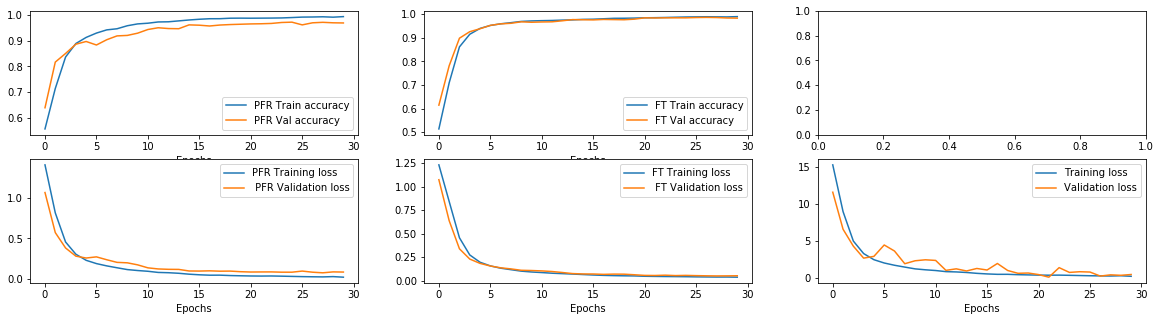

In [17]:
def  plot_train_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(20, 5))
    axes[0][0].plot(history.history['PFR_accuracy'], label='PFR Train accuracy')
    axes[0][0].plot(history.history['val_PFR_accuracy'], label='PFR Val accuracy')
    axes[0][0].set_xlabel('Epochs')
    axes[0][0].legend()
    
    axes[0][1].plot(history.history['FT_accuracy'], label='FT Train accuracy')
    axes[0][1].plot(history.history['val_FT_accuracy'], label='FT Val accuracy')
    axes[0][1].set_xlabel('Epochs')
    axes[0][1].legend()

    axes[1][2].plot(history.history['loss'], label='Training loss')
    axes[1][2].plot(history.history['val_loss'], label='Validation loss')
    axes[1][2].set_xlabel('Epochs')
    axes[1][2].legend()
    
    axes[1][0].plot(history.history['PFR_loss'], label='PFR Training loss')
    axes[1][0].plot(history.history['val_PFR_loss'], label=' PFR Validation loss')
    axes[1][0].set_xlabel('Epochs')
    axes[1][0].legend()
    
    axes[1][1].plot(history.history['FT_loss'], label='FT Training loss')
    axes[1][1].plot(history.history['val_FT_loss'], label=' FT Validation loss')
    axes[1][1].set_xlabel('Epochs')
    axes[1][1].legend()
    plt.savefig('../Models/MTL/'+filename+pngExt)

plot_train_history(H)

In [18]:
def save_model(model,path,h5Name,jsonName):
    model.save_weights(path+h5Name)
    with open(path+jsonName, 'w') as f:
        f.write(model.to_json())
        
def load_model(path, h5Name,jsonName):
    from keras.models import model_from_json
    with open(path+jsonName, 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(path+h5Name)
    
    return model

In [19]:

h5Name = filename+h5Ext
jsonName = filename+jsonExt
path = '../Models/MTL/'

In [20]:

save_model(model3,path,h5Name,jsonName)

In [21]:
model = load_model(path,h5Name,jsonName)

In [22]:
STEP_SIZE_TEST

24

In [ ]:
test_gen = get_data_generator(labels,'test',batch_size)
x_test, (pfr_true, ft_true)= next(test_gen,1600)
pfr_pred, ft_pred = model3.predict_on_batch(x_test)

In [ ]:
pfr_true, ft_true = pfr_true.argmax(axis=-1), ft_true.argmax(axis=-1)
pfr_pred, ft_pred = pfr_pred.argmax(axis=-1), ft_pred.argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for PFR")
print(classification_report(pfr_true, pfr_pred))

print("\nClassification report for FT")
print(classification_report(ft_true, ft_pred))

In [ ]:
# COnfusion Matrix Train

In [23]:
gen2 = CustonGen()
from sklearn.metrics import confusion_matrix

In [37]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'train',batch_size), STEP_SIZE_TRAIN+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.trainClsPfr[0:pfr.shape[0]]
truft = gen2.trainClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[4003    3    0    0    0    0    1    0    0    0]
 [  14  357    0    0    0    0    0    0    0    0]
 [   0   15  636    6    0    0    0    0   24    0]
 [   0    0    3  214    0    0    0    0    0    0]
 [   0    0    0    1  305    0    0    0    0    0]
 [   0    0    0    0    0  280    0    0    0    0]
 [   0   10    0    0    0    0  480    0    0    0]
 [   0    0    0    0    0   13    0  111    0    0]
 [   0    0    0    0    0    0    6    0  717    0]
 [   0    0    0    0    0    0    0    0    0  161]]
Confusion Matrix for ft
[[1636    1    4    0    1]
 [   0 1301    0    0   34]
 [  14    0  183    0    0]
 [   1    0    0  751    0]
 [   0   20    0    0 3414]]


In [25]:
# on vald

In [39]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'vald',batch_size), STEP_SIZE_VALID+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.valdClsPfr[0:pfr.shape[0]]
truft = gen2.valdClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[874   0   0   0   0   0   0   0   0   0]
 [  7  83   0   0   0   0   0   0   1   0]
 [  0   5 154   5   0   0   0   0  11   0]
 [  0   0   2  43   0   0   0   0   0   0]
 [  0   0   0   3  60   0   0   0   0   0]
 [  0   0   0   0   0  44   0   0   0   0]
 [  2   3   0   0   0   0  98   0   3   0]
 [  0   0   0   0   0   0   0  19   0   0]
 [  0   0   0   0   0   0   4   0 150   0]
 [  0   0   0   0   0   1   0   0   0  28]]
Confusion Matrix for ft
[[348   0   0   0   1]
 [  0 279   0   0  14]
 [  5   0  39   0   0]
 [  0   0   0 176   0]
 [  0   5   0   0 733]]


In [40]:
pfr,ft = model3.predict_generator(gen2.get_data_generator(labels,'test',batch_size), STEP_SIZE_TEST+1)
pfr,ft  = pfr.argmax(axis=-1), ft.argmax(axis=-1)
trupfr = gen2.testClsPfr[0:pfr.shape[0]]
truft = gen2.testClsFt[0:ft.shape[0]]

print('Confusion Matrix for pfr')
print(confusion_matrix(trupfr, pfr))

print('Confusion Matrix for ft')
print(confusion_matrix(truft, ft))

Confusion Matrix for pfr
[[867   1   0   0   0   0   4   0   0   0]
 [  3  58   0   0   0   0   2   0   0   0]
 [  0   9 161   6   0   0   0   0  15   0]
 [  0   0   5  42   0   0   0   0   0   0]
 [  0   0   0   0  65   0   0   0   0   0]
 [  0   0   0   0   0  48   0   1   0   2]
 [  2   4   0   0   0   0  85   0   2   0]
 [  0   0   0   0   0   1   0  17   0   0]
 [  0   0   0   0   0   0   8   0 158   0]
 [  0   0   0   0   0   0   0   0   0  34]]
Confusion Matrix for ft
[[360   1   1   0   0]
 [  0 319   0   0  10]
 [  2   0  43   0   2]
 [  0   0   0 138   0]
 [  0   4   0   0 720]]


In [43]:
cm = confusion_matrix(truft, ft)
cm

array([[360,   1,   1,   0,   0],
       [  0, 319,   0,   0,  10],
       [  2,   0,  43,   0,   2],
       [  0,   0,   0, 138,   0],
       [  0,   4,   0,   0, 720]], dtype=int64)

In [44]:
cmd = pd.DataFrame(cm)

In [45]:
cmd

,0,1,2,3,4
0,360,1,1,0,0
1,0,319,0,0,10
2,2,0,43,0,2
3,0,0,0,138,0
4,0,4,0,0,720
